# Градиентный бустинг своими руками

Здесь будет использоваться датасет `boston` из `sklearn.datasets`. Оставим последние 25% объектов для контроля качества, разделив `X` и `y` на `X_train`, `y_train` и `X_test`, `y_test`.

Целью будет реализация простого варианта градиентного бустинга над регрессионными деревьями для случая квадратичной функции потерь.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_boston

raw_data = load_boston()
X = raw_data.data
y = raw_data.target

In [2]:
X_train = X[:int(X.shape[0] * 0.75)]
y_train = y[:int(y.shape[0] * 0.75)]
X_test  = X[int(X.shape[0] * 0.75):]
y_test  = y[int(y.shape[0] * 0.75):] 

##  Подготовка к градиентному бустингу

Градиентный бустинг обучает каждый новый алгоритм так, чтобы он приближал антиградиент ошибки по ответам композиции на обучающей выборке. Аналогично минимизации функций методом градиентного спуска, в градиентном бустинге мы подправляем композицию, изменяя алгоритм в направлении антиградиента ошибки.

Найдём функцию задающую ответы на обучающей выборке, на которые нужно обучать новый алгоритм, если функция потерь `L` - квадрат отклонения ответа композиции `a(x)` от правильного ответа `y` на данном `x`.

In [3]:
def L(x, y):
    return y - x

## Градиентный бустинг на 50 деревьях

В качестве базовых алгоритмов будем использовать 50 `DecisionTreeRegressor`. Заведём массив для деревьев и коэффициентов перед ними.

Попробуем выставить значения коэффициентов равными 0.9.

Оценим ошибку с помощью `RMSE`.

In [4]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

In [5]:
def gbm_predict(X):
    return [sum([coeff * algo.predict([x])[0] for algo, coeff 
                 in zip(base_algorithms_list, coefficients_list)]) for x in X]

def RMSE(target, predict):
    return np.sqrt(mean_squared_error(target, predict))

In [6]:
base_algorithms_list = []
coefficients_list = []
y_on_current_iteration = np.array(y_train)

for i in range(50):
    regressor = DecisionTreeRegressor(max_depth=5, random_state=42).fit(X_train, y_on_current_iteration)
    base_algorithms_list.append(regressor)
    coefficients_list.append(0.9)
    
    y_on_current_iteration = L(gbm_predict(X_train), y_train)

In [7]:
print(RMSE(y_test, gbm_predict(X_test)))

5.455623403859612


### Оптимизируем шаг
Чтобы не перепрыгивать минимум, будем уменшать веса на каждом шаге в `1 / (1.0 + i)` раз

In [8]:
base_algorithms_list = []
coefficients_list = []
y_on_current_iteration = np.array(y_train)

for i in range(50):
    regressor = DecisionTreeRegressor(max_depth=5, random_state=42).fit(X_train, y_on_current_iteration)
    base_algorithms_list.append(regressor)
    coefficients_list.append(0.9 / (1.0 + i))
    
    y_on_current_iteration = L(gbm_predict(X_train), y_train)

In [9]:
print(RMSE(y_test, gbm_predict(X_test)))

4.812550945781193


## Готовые решения
Импортируем библиотеку `xgboost`. Посмотрим, как ведёт себя градиентный бустинг при росте числа итераций, глубины деревьев.

In [10]:
import xgboost as xgb
import matplotlib.pyplot as plt

Посмотрим, как влияет количество деревьев на качество модели.

In [11]:
errors_on_test = []
errors_on_train = []

for i in range(50):
    regressor = xgb.XGBRegressor(n_estimators=i, n_jobs=4, random_state=42, max_depth=5, eval_metric='rmse')
    regressor.fit(X_train, y_train)
    predict = regressor.predict(X_test)
    errors_on_test.append(RMSE(y_test, predict))
    predict = regressor.predict(X_train)
    errors_on_train.append(RMSE(y_train, predict))

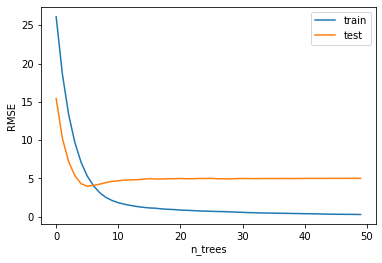

In [12]:
plt.plot(range(50), errors_on_train, label='train')
plt.plot(range(50), errors_on_test, label='test')
plt.xlabel('n_trees')
plt.ylabel('RMSE')
plt.legend()

С увеличением числа деревьев, начиная с некоторого момента (примерно на 5 итерации), градиентный бустинг начинает переобучаться.

Посмотрим, как влияет глубина деревьев на качество модели.

In [13]:
errors_on_test = []
errors_on_train = []

for i in range(50):
    regressor = xgb.XGBRegressor(n_estimators=100, n_jobs=4, random_state=42, max_depth=i, eval_metric='rmse')
    regressor.fit(X_train, y_train)
    predict = regressor.predict(X_test)
    errors_on_test.append(RMSE(y_test, predict))
    predict = regressor.predict(X_train)
    errors_on_train.append(RMSE(y_train, predict))

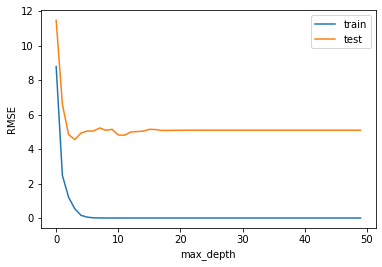

In [14]:
plt.plot(range(50), errors_on_train, label='train')
plt.plot(range(50), errors_on_test, label='test')
plt.xlabel('max_depth')
plt.ylabel('RMSE')
plt.legend()

С ростом глубины деревьев, начиная с некоторого момента (примерно с 4 итерации), качество работы градиентного бустинга на тестовой выборке начинает ухудшаться.

## Линейная регрессия или градиентный бустинг?

Сравним получаемое с помощью градиентного бустинга качество с качеством работы линейной регрессии `LinearRegression` из `sklearn.linear_model` на наших данных.

In [15]:
from sklearn.linear_model import LinearRegression

regressor = LinearRegression()
regressor.fit(X_train, y_train)
predict = regressor.predict(X_test)
print(RMSE(y_test, predict))

8.254979753549161


Видно, что градиентный бустинг над решающими деревьями справился лучше, чем линейная регрессия. Но нельзя утдверждать, что это общий результат. Скорее всего всё зависит от выборки.